# Sequential Model-Based Optimization on a 1-D problem

Manoj Kumar, August 2016.

In this problem we illustrate the Sequential model-based optimization loop on a toy 1-D problem with `gp_minimize`. The function to be minimized is $$\sin(5x) * (1 - \tanh(x^2))$$

## Requirements

For Sequential model-based optimization loop one requires the following:
1. A regressor that can give an estimate of $P(Y_{new} | X_{new}; X_{old}, Y_{old})$.
2. An acquisition function that can be minimized easily and ideally gives a trade-off between exploitation
and exploration using $P(Y_{new} | X_{new}; X_{old}, Y_{old})$.
3. A minimizer to minimize the acquisition function.
4. A few initial points (random or points chosen based on some prior) to fit the regressor initially.
5. A convergence critertion to stop the minimization routine

## Loop description

1. Fit the regressor based on the initial points.
2. Repeat till convergence critertion:
   1. Minimize the acquisition function using the posterior estimates obtained from the regressor.
   2. Fit the regressor based on the updated points.


In [1]:
import numpy as np
import matplotlib.pyplot as plt

from skopt import gp_minimize
from skopt.benchmarks import bench3
from skopt.acquisition import gaussian_lcb

%matplotlib inline

We shall have a quick look at the true function.

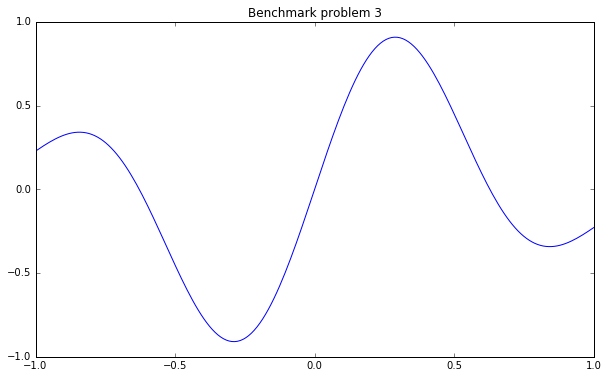

In [2]:
dimensions = [(-1.0, 1.0)]
x_values_1D = np.linspace(-1, 1, 200)
x_values = x_values_1D.reshape(-1, 1)
func_values = [bench3(xi) for xi in x_values]

plt.rcParams["figure.figsize"] = (10, 6)
plt.title("Benchmark problem 3")
plt.plot(x_values, func_values)
plt.show()

In this example, we use the following:

1. A GaussianProcess as a regressor. The posterior estimates obtained from the GaussianProcess for a new point is a gaussian with a mean(A) and variance(B) described here (https://en.wikipedia.org/wiki/Gaussian_process#Gaussian_process_prediction.2C_or_kriging)

2. The acquisition function is the "lower confidence bound". This is $\mu - 1.96 \sigma$. $\mu$ is the exploitation factor and $\sigma$ is the exploration factor. We try to achieve a balance between choosing points close and far away to the previous minimum.

3. We use the "lbfgs" optimizer from (https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.fmin_l_bfgs_b.html). Note this is not a great solution for points in which there is more than one local minimum. Hence we restart the optimizer at 5 different points (can be set by the parameter `n_restarts_optimizer.`)

4. The initial point in this case is a single point that is chosen randomly.

5. We set the optimization procedure to finish when the expensive function (in this case, not-so expensive) has been called 6 times, including the function evaluation at the random point.

In [3]:
res = gp_minimize(bench3, dimensions, n_calls=6, n_random_starts=1, random_state=0, acq="LCB")
best_xs = res.x_iters
best_ys = res.func_vals
models = res.models

All optimization routines in `skopt` return an `OptimizeResult` with a lot of valuable information. For this example, however we require only the attributes

1. `x_iter` (Location of the minimum at every iteration)
2. `func_vals` (Function evaluation at every iteration)
3. `models` (The fit `GaussianProcessRegressor` models at every iteration)

and don't burden ourselves to know what the other attributes are.

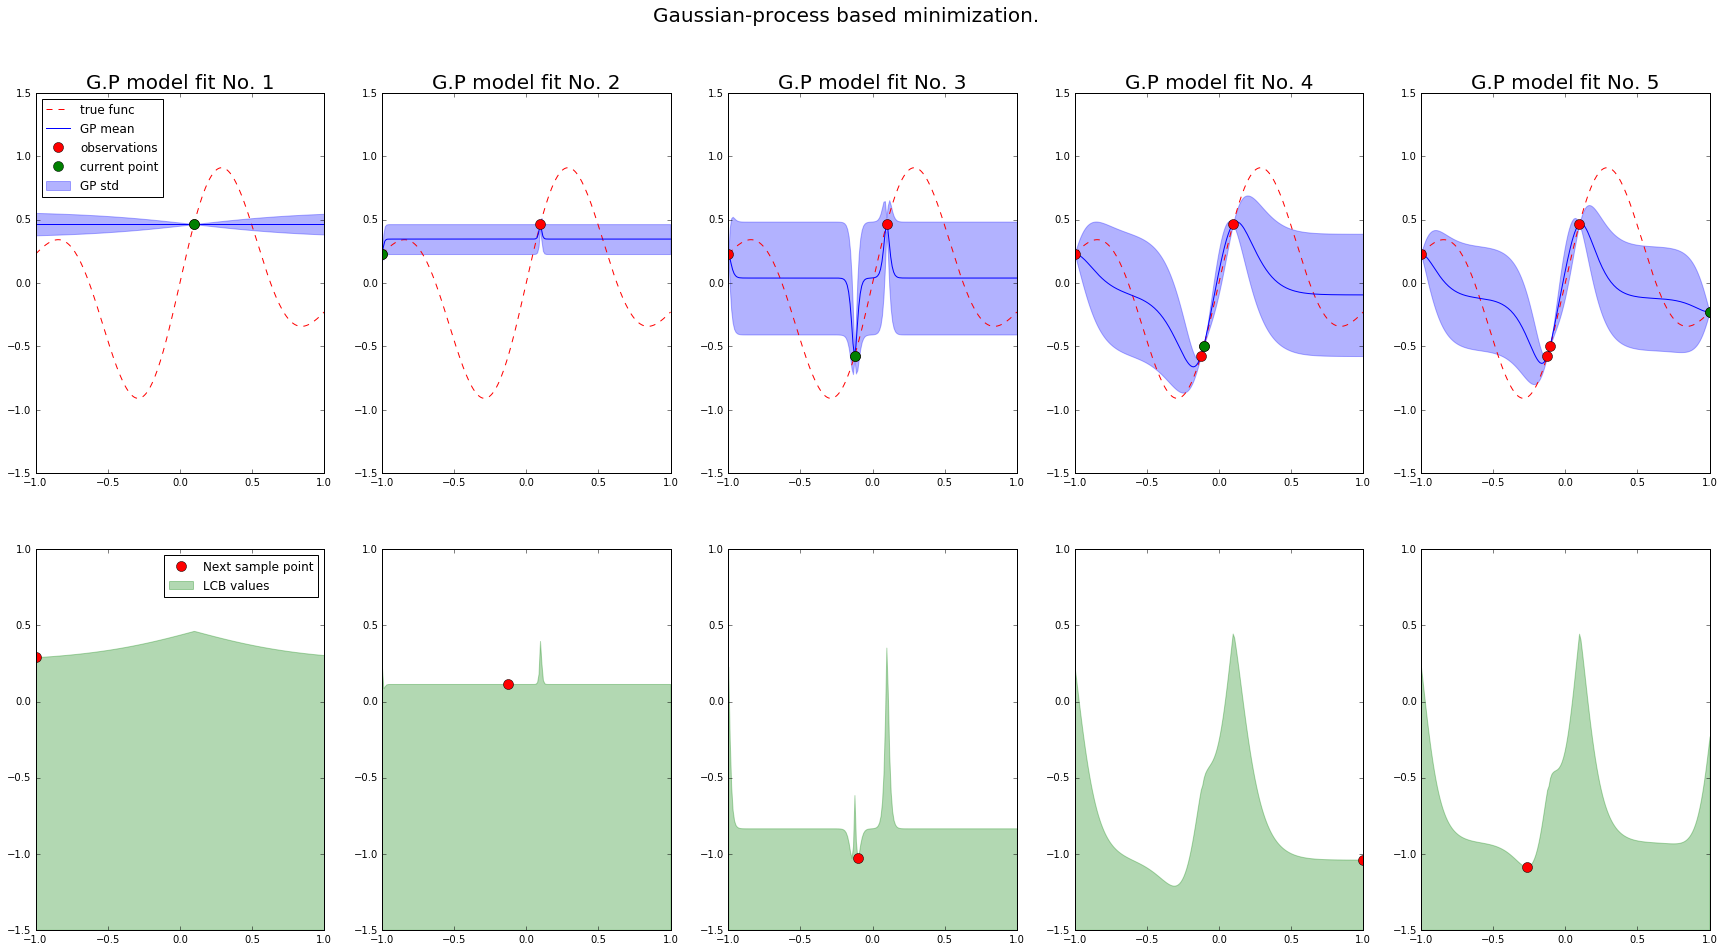

In [4]:
plt.rcParams["figure.figsize"] = (30, 15)

for n_iter in range(5):
    curr_model = models[n_iter]
    curr_best_xs = best_xs[: n_iter+1]
    curr_best_y = best_ys[: n_iter+1]

    mean, std = curr_model.predict(x_values, return_std=True)
    acquis_values = gaussian_lcb(x_values, curr_model).ravel()
    posterior_mean = mean.ravel()
    posterior_std = std.ravel()
    upper_bound = posterior_mean + posterior_std
    lower_bound = posterior_mean - posterior_std

    plt.subplot(2, 5, n_iter + 1)
    plt.plot(x_values_1D, func_values, color='red', linestyle="--", label="true func")
    plt.plot(x_values_1D, posterior_mean, color='blue', label="GP mean")
    plt.fill_between(
        x_values_1D, lower_bound, upper_bound, alpha=0.3, color='blue', label="GP std")

    plt.plot(np.asarray(curr_best_xs).ravel(), curr_best_y, 'ro', label="observations", markersize=10)
    plt.plot(best_xs[n_iter], best_ys[n_iter], 'go', label="current point", markersize=10)
    plt.title("G.P model fit No. %d" % (n_iter + 1), fontsize=20)
    plt.ylim([-1.5, 1.5])

    if n_iter == 0:
        plt.legend(loc="best", prop={'size': 12}, numpoints=1)

    plt.subplot(2, 5, n_iter + 6)
    plt.fill_between(x_values_1D, -1.5, acquis_values, alpha=0.3, color='green',
                     label="LCB values")

    next_x = np.asarray(best_xs[n_iter + 1])
    plt.plot(next_x, gaussian_lcb(next_x.reshape(-1, 1), curr_model), "ro", markersize=10, label="Next sample point")
    plt.ylim([-1.5, 1.0])

    if n_iter == 0:
        plt.legend(loc="best", prop={'size': 12}, numpoints=1)

plt.suptitle("Gaussian-process based minimization.", fontsize=20)
plt.show()

The first row shows the following:
1. The true function. (Given by the red line)
2. The approximation to the original function by the GaussianProcess model. (Given by the blue line)
3. How sure the GP is about the function. (Given by the shaded blue region)

It is worth noting that as more number of points are sampled, the GP forms a really good approximation to the true function. Also at points closer to the points previously evaluated at, the variance dips to zero.

The second row shows the acquisition function values after every surrogate model is fit. Note that it is absolutely possible that we do not choose the global minimum but a local minimum as explained under the previous section.